# 1. References

Title: Multi-Label Classification(Blog Tags Prediction)using NLP

Link: https://medium.com/coinmonks/multi-label-classification-blog-tags-prediction-using-nlp-b0b5ee6686fc

Naive approach is to do x -> y1, x -> y1, y2, x -> y1, y2, y3

# 2. Imports

# 3. Creation of a valid dataframe - one hot encoding style

In [38]:
file_name = 'TED_Talks_by_ID_plus-transcripts-and-LIWC-and-MFT-plus-views.csv'
df = pd.read_csv('../owentemple-ted-talks-complete-list/{}'.format(file_name))
df.head()

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,...,harm_vice,fairness_virtue,fairness_vice,ingroup_virtue,ingroup_vice,authority_virtue,authority_vice,purity_virtue,purity_vice,morality_general
0,1,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,http://www.ted.com/talks/view/id/1/transcript?...,2,2006,TED2006,0:16:17,...,0.04,0.00,0.00,0.48,0.00,0.22,0.0,0.00,0.00,0.22
1,2,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,http://www.ted.com/talks/view/id/2/transcript?...,2,2006,TED2006,0:15:06,...,0.04,0.00,0.00,0.30,0.00,0.11,0.0,0.11,0.04,0.15
2,3,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,http://www.ted.com/talks/view/id/3/transcript?...,7,2005,TEDGlobal 2005,0:18:45,...,0.12,0.16,0.04,0.32,0.12,0.20,0.0,0.04,0.04,0.08
3,4,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",http://www.ted.com/talks/view/id/4/transcript?...,2,2006,TED2006,0:19:37,...,0.19,0.00,0.00,0.19,0.00,0.10,0.0,0.00,0.00,0.16
4,5,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,http://www.ted.com/talks/view/id/5/transcript?...,2,2002,TED2002,0:20:04,...,0.05,0.03,0.00,0.39,0.00,0.05,0.0,0.00,0.03,0.13


In [39]:
df.iloc[:,:15].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 15 columns):
id                      2475 non-null int64
speaker                 2475 non-null object
headline                2475 non-null object
URL                     2475 non-null object
description             2475 non-null object
transcript_URL          2386 non-null object
month_filmed            2475 non-null int64
year_filmed             2475 non-null int64
event                   2475 non-null object
duration                2475 non-null object
date_published          2475 non-null object
views_as_of_06162017    2474 non-null float64
tags                    2475 non-null object
transcript              2386 non-null object
notes                   4 non-null object
dtypes: float64(1), int64(3), object(11)
memory usage: 290.1+ KB


## 3.1 Remove nan transcripts

In [40]:
df = df.dropna(subset=['transcript'])
df = df.reset_index(drop=True)
df.iloc[:,:15].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 15 columns):
id                      2386 non-null int64
speaker                 2386 non-null object
headline                2386 non-null object
URL                     2386 non-null object
description             2386 non-null object
transcript_URL          2386 non-null object
month_filmed            2386 non-null int64
year_filmed             2386 non-null int64
event                   2386 non-null object
duration                2386 non-null object
date_published          2386 non-null object
views_as_of_06162017    2386 non-null float64
tags                    2386 non-null object
transcript              2386 non-null object
notes                   4 non-null object
dtypes: float64(1), int64(3), object(11)
memory usage: 279.7+ KB


## 3.2 Finding the unique tags

In [46]:
joined_tags = df['tags'].str.cat(sep=',').split(',')
all_tags = pd.Series(joined_tags).str.strip().str.lower()
all_tags = list(dict.fromkeys(all_tags))
all_tags.remove('')
print(all_tags)
print(len(all_tags))

['cars', 'alternative energy', 'culture', 'politics', 'science', 'climate change', 'environment', 'sustainability', 'global issues', 'technology', 'macarthur grant', 'simplicity', 'industrial design', 'invention', 'engineering', 'design', 'corruption', 'poverty', 'economics', 'investment', 'military', 'policy', 'global development', 'entrepreneur', 'business', 'aircraft', 'flight', 'nasa', 'rocket science', 'transportation', 'art', 'biotech', 'oceans', 'genetics', 'dna', 'biology', 'biodiversity', 'ecology', 'computers', 'software', 'interface design', 'music', 'media', 'entertainment', 'performance', 'new york', 'memory', 'interview', 'death', 'architecture', 'disaster relief', 'cities', 'urban planning', 'collaboration', 'robots', 'education', 'innovation', 'social change', 'obesity', 'disease', 'health', 'health care', 'food', 'primates', 'africa', 'animals', 'nature', 'wunderkind', 'cancer', 'creativity', 'love', 'gender', 'relationships', 'cognitive science', 'psychology', 'evolut

## 3.3 Creating a new dataframe

In [75]:
def create_one_hot_encode(df=df):
    complete_transcripts_tags = []
    for rows, value in df.iterrows():
        one_hot_encoding = [0] * 417
        transcript = [value['transcript']]
        indiv_tags = value['tags'].split(',')
        for tags in indiv_tags:
            if tags == '':
                continue
            index = all_tags.index(tags.lower().lstrip(' '))
            one_hot_encoding[index] = 1
        indiv_transcript_tags = transcript + one_hot_encoding
        complete_transcripts_tags.append(indiv_transcript_tags)
    return pd.DataFrame(complete_transcripts_tags, columns=['transcript'] + all_tags)

In [76]:
ted_tags = create_one_hot_encode()
ted_tags

,transcript,cars,alternative energy,culture,politics,science,climate change,environment,sustainability,global issues,...,anthropocene,syria,movies,ted residency,ted-ed,telescopes,ted en espanol,alzheimer's,ted en español,epidemiology
0,"0:14\r\r\rThank you so much, Chris.\rAnd it's ...",1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,"0:11\r\r\rIn terms of invention,\rI'd like to ...",0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,"0:12\r\r\rA public, Dewey long ago observed,\r...",0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,"0:11\r\r\rI want to start off by saying, Houst...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"0:12\r\r\rWhat I want to talk about is, as bac...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"0:11\r\r\rAt the break, I was asked by several...",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"0:12\r\r\r(Music: ""The Sound of Silence,""\rSim...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"0:13\r\r\rKurt Andersen: Like many architects,...",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"0:11\r\r\rAs you pointed out, every time you c...",1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,0:11\r\r\rWith all the legitimate concerns\rab...,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# 4. Cleaning the data

In [78]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords
stopWordList=stopwords.words('english')
stopWordList.remove('no')
stopWordList.remove('not')
lemma=WordNetLemmatizer()
token=ToktokTokenizer()

In [90]:
import unicodedata

def removeAscendingChar(data):
    data=unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return data

def removeCharDigit(text):
    str="`1234567890-=~@#$%^&*()_+[!{;”:\’><.,/?”}]"
    for w in text:
        if w in str:
            text=text.replace(w,'')
    return text

def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w,'v')
        listLemma.append(x)
    return text


def stopWordsRemove(text):
    wordList=[x.lower().strip() for x in token.tokenize(text)]
    removedList=[x for x in wordList if not x in stopWordList]
    text=''.join(removedList)
    return text

In [122]:
import re 

def PreProcessing(text):
    text=removeCharDigit(text)
    text=removeAscendingChar(text)
    text=lemitizeWords(text)
    text=stopWordsRemove(text)
    return(text)


banned = ["\\\"", "\""]
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what’s", "what is", text)
    text = re.sub(r"’s", "", text)
    text = re.sub(r"'s", "", text)
    text = re.sub(r"’ve", ' have', text)
    text = re.sub(r"'ve", ' have', text)
    text = re.sub(r"can’t", "cannot", text)
    text = re.sub(r"can't", "not", text)
    text = re.sub(r"won’t", "would not", text)
    text = re.sub(r"won't", "would not", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"i\'m", "i am", text)
    text = re.sub(r"’re", " are", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"’d", " would", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"’ll", " will", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"\’scuse", "excuse", text)
    text = re.sub(r"\'scuse", "excuse", text)
#     text = re.sub('\W', '', text)
    #text = re.sub('\s+', ' ', text)
    # Stuff that is in this document
    for i in banned:
        text = text.replace(i, " " )
    text = text.replace("'", "" )
    text = re.sub('\s+', ' ', text)
    return text

In [123]:
from copy import deepcopy
ted_tags_copy = deepcopy(ted_tags)
ted_tags_copy['transcript'] = ted_tags_copy['transcript'].map(lambda com : clean_text(com))
ted_tags_copy['transcript'] = ted_tags_copy['transcript'].map(lambda com : PreProcessing(com))
ted_tags_copy

,transcript,cars,alternative energy,culture,politics,science,climate change,environment,sustainability,global issues,...,anthropocene,syria,movies,ted residency,ted-ed,telescopes,ted en espanol,alzheimer's,ted en español,epidemiology
0,thank much chris truly great honor opportunity...,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,terms invention would like tell tale one favor...,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,public dewey long ago observed constituted dis...,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,want start saying houston problem entering sec...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,want talk background idea cars art actually qu...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,break asked several people comments aging deba...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,music sound silence simon garfunkel hello voic...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,kurt andersen like many architects david hog l...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,pointed every time come learn something mornin...,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,legitimate concerns aids avian flu hear brilli...,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [109]:
ted_tags_glenn = deepcopy(ted_tags)

ted_tags_glenn['transcript'] = ted_tags_glenn['transcript'].str.replace(r'\d+','')
ted_tags_glenn['transcript'] = ted_tags_glenn['transcript'].str.replace(r'<.*?>','')
for i in string.punctuation:
    if i == "'":
        ted_tags_glenn['transcript'] = ted_tags_glenn['transcript'].str.replace(i,'')
    else:
        ted_tags_glenn['transcript'] = ted_tags_glenn['transcript'].str.replace(i,' ')
ted_tags_glenn['transcript'] = ted_tags_glenn['transcript'].str.replace('\s+',' ')
ted_tags_glenn['transcript'] = ted_tags_glenn['transcript'].map(lambda com : PreProcessing(com))

In [124]:
ted_tags['transcript'][0]

'0:14\r\r\rThank you so much, Chris.\rAnd it\'s truly a great honor\rto have the opportunity\rto come to this stage twice;\rI\'m extremely grateful.\rI have been blown away by this conference,\rand I want to thank all of you\rfor the many nice comments\rabout what I had to say the other night.\rAnd I say that sincerely,\rpartly because (Mock sob)\rI need that.\r\r\r\r\r 0:40\r\r\r(Laughter)\r\r\r\r\r 0:45\r\r\rPut yourselves in my position.\r\r\r\r\r 0:47\r\r\r(Laughter)\r\r\r\r\r 0:54\r\r\rI flew on Air Force Two for eight years.\r\r\r\r\r 0:57\r\r\r(Laughter)\r\r\r\r\r 0:59\r\r\rNow I have to take off my shoes\ror boots to get on an airplane!\r\r\r\r\r 1:02\r\r\r(Laughter)\r\r\r\r\r 1:05\r\r\r(Applause)\r\r\r\r\r 1:11\r\r\rI\'ll tell you one quick story\rto illustrate what\rthat\'s been like for me.\r\r\r\r\r 1:16\r\r\r(Laughter)\r\r\r\r\r 1:18\r\r\rIt\'s a true story \revery bit of this is true.\r\r\r\r\r 1:21\r\r\rSoon after Tipper and I left the \r(Mock sob) White House \r\r\r\r\r

In [125]:
ted_tags_copy['transcript'][0]

'thank much chris truly great honor opportunity come stage twice extremely grateful blown away conference want thank many nice comments say night say sincerely partly mock sob need laughter put position laughter flew air force two eight years laughter take shoes boots get airplane laughter applause tell one quick story illustrate like laughter true story every bit true soon tipper left mock sob white house laughter driving home nashville little farm miles east nashville driving laughter know sounds like little thing laughter looked rearview mirror sudden hit no motorcade back laughter heard phantom limb pain laughter rented ford taurus laughter dinnertime started looking place eat got exit lebanon tennessee got exit found shoney restaurant lowcost family restaurant chain dont know went sat booth waitress came made big commotion tipper laughter took order went couple booth next us lowered voice much really strain hear saying said yes former vice president al gore wife tipper man said co

In [110]:
ted_tags_glenn['transcript'][0]

'thank much chris truly great honor opportunity come stage twice im extremely grateful blown away conference want thank many nice comments say night say sincerely partly mock sob need laughter put position laughter flew air force two eight years laughter take shoes boots get airplane laughter applause ill tell one quick story illustrate thats like laughter true story every bit true soon tipper left mock sob white house laughter driving home nashville little farm miles east nashville driving laughter know sounds like little thing laughter looked rear view mirror sudden hit no motorcade back laughter youve heard phantom limb pain laughter rented ford taurus laughter dinnertime started looking place eat got exit lebanon tennessee got exit found shoneys restaurant low cost family restaurant chain dont know went sat booth waitress came made big commotion tipper laughter took order went couple booth next us lowered voice much really strain hear saying said yes thats former vice president al 

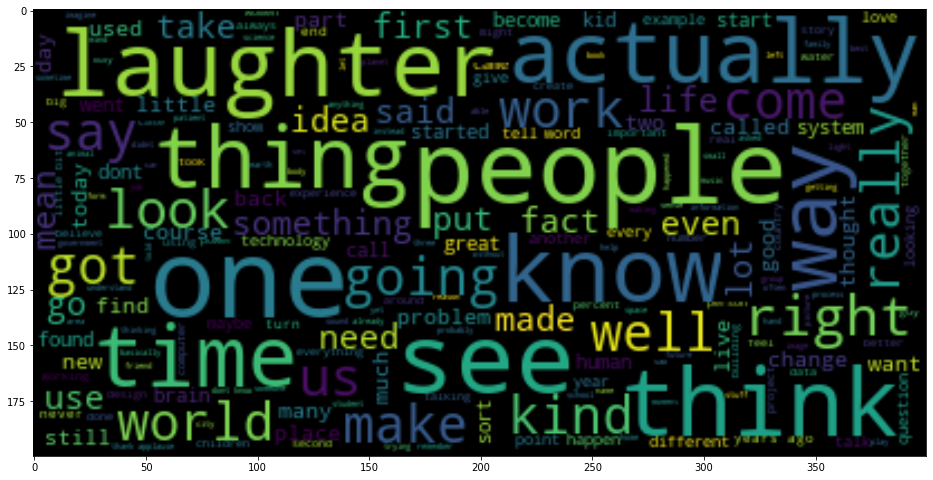

In [132]:
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

totalText=''
for x in ted_tags_copy['transcript']:
    ps=PreProcessing(x)
    totalText=totalText+''+ps
wc=WordCloud(background_color='black',max_font_size=50).generate(totalText)
plt.figure(figsize=(16,12))
plt.imshow(wc, interpolation='bilinear')

# 5. Machine Learning part

In [141]:
x=ted_tags_copy.iloc[:,0].values
y=ted_tags_copy.iloc[:,1:-1].values


In [138]:
from sklearn.feature_extraction.text import CountVectorizer
body = ted_tags_copy.transcript
cv = CountVectorizer().fit(body)
article = pd.DataFrame(cv.transform(body).todense(),columns=cv.get_feature_names())

In [142]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfart=TfidfTransformer().fit(article)
art=pd.DataFrame(tfidfart.transform(article).todense())

In [143]:
!pip install scikit-multilearn

# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
xtrain,xtest,ytrain,ytest=train_test_split(art,y)
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(xtrain.astype(float), ytrain.astype(float))

predictions = classifier.predict(xtest.astype(float))
predictions.toarray()
from sklearn.metrics import accuracy_score
accuracy_score(ytest.astype(float),predictions)

0.0016750418760469012

In [163]:
print(ytest)
print(ytest.sum(axis=1))

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[ 4 12  6  7  7  5  4  6  9  6 13 11 11 22  5  6  4  2 15 19 14  4  4 16
  9 14  4  8 13  7  5  7 10  5  8  9  8  6  3  8 14  3  5 14  6  6 12  5
  6  7 14  4  5  7  3  6  6  6  7 33  7  7  7  4  8  3  5 10  6  7  3 10
  5 15  6  6 10 18  7  6 10  9  4  6  3  4  7  5  3  8 15  6  5 16  6  3
  5 11 19  7  6  8  4  4  9  6 11  9  4  5 16  4  7  3  4  7  6  8  5 13
  5 14 10  7  9  3  9  4  8  7  8 13  3  6 11  5  8  6 10  4  5  9 22  9
  4  6  6  4 14  5  5  7 13  9 12  6  4  5  4  6  6  6  5  4  5  5  4  6
  3  5  6  4  4  4  7 10  6  4  6  7  6  6  7  6  9  6  9  5  5  6  4 11
  7  5  4  9  3 12 24  7  7  6  5 13  5  3  8  7  8  6  5  9  5  5 18  9
  7  6  3  6  3  9  7  6 11  6  3  8  4  9  7  7  3  3  6  6 10  8  7 14
  3  4  5  7  4  6  6  8  4  5  4  6  5  8 13  5  5  6  7  5  6  4  7  8
 10  9 16  7  7  5  6 12 12  7  5  6  7  3 17  3  5 12 13  5  6  6  5  7
 10 

In [149]:
predictions = classifier.predict(xtest.astype(float))

In [162]:
print(predictions.toarray().sum(axis=1))
print(type(predictions))

[ 0.  2.  0.  2.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  1.  0.  2.  1.
  2.  1.  0.  0.  0.  0.  2.  1.  1.  1.  0.  0.  0.  1.  0.  3.  0.  0.
  1.  0.  1.  0.  0.  3.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  2.
  0.  0.  2.  1.  0.  1.  2.  0.  1.  0.  0.  0.  1.  2.  0.  0.  0.  0.
  0.  2.  0.  0.  0.  0.  1.  0.  0.  1.  7.  0.  0.  0.  0.  2.  1.  0.
  0.  0.  0.  0.  3.  1.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  1.  0.
  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  2.  0.
  0.  7.  2.  2.  2.  2.  0.  0.  4.  1.  2.  1.  0.  1.  0.  0.  0.  1.
  2.  0.  0.  0.  3.  0.  1.  0. 11.  0.  1.  0.  1.  0.  0.  2.  0.  0.
  0.  1.  0.  0.  0.  1.  2.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  2.  0.  0.  0.  5.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.
  1.  0.  1.  0.  0.  0.  5.  0.  0.  0.  0.  0.  6